**Collaborateurs**

- Jean-Baptiste CHEZE  
- Théo Linale  
- Annastasiia Sevelvoka  

**Contexte du projet**

Dans ce projet, nous avons développé deux modèles OCR pour la résolution automatique de CAPTCHAs visuels :

- un modèle construit from scratch, basé sur une architecture CNN + BiLSTM puis fine-tuné
- un modèle pré-entraîné (TR-OCR de Microsoft), adapté par fine-tuning.

Le notebook se concentre principalement sur la conception, l’entraînement et l’évaluation de ces deux modèles, ainsi que sur la comparaison de leurs performances.

Il est important de noter que ce travail s’inscrit dans un système plus large, comprenant également :

- une partie de webscraping pour la collecte des CAPTCHAs ;
- une API permettant d’orchestrer les différentes briques du projet ;
- une interface front-end développée avec Streamlit.

Dans un premier temps, vous allez voir le code ayant permis de construire la pipeline complète du modèle OCR avant la phase de fine-tuning.

Il est important de souligner que ce notebook présente uniquement le résultat final du travail réalisé. Le développement du modèle a nécessité un processus long et itératif, comprenant de nombreux tests, ajustements et expérimentations.

Pour concevoir cette pipeline, nous nous sommes principalement appuyés sur la documentation officielle de Keras, notamment l’exemple suivant :  
https://keras.io/examples/vision/captcha_ocr/

Nous avons également mobilisé d’autres sources, telles que :

- des ressources pédagogiques (articles, tutoriels, vidéos YouTube) ;
- des outils d’IA générative, utilisés comme support pour l’exploration de solutions techniques et l’optimisation du code.


### 1. Pipeline complète Modèle From Scratch

Le modèle a été entraîné sur 9 sources de données distinctes, chacune contenant environ 10 000 images de CAPTCHA annotés.

Les choix liés aux jeux de données, au processus d’entraînement ainsi qu’aux différentes étapes d’expérimentation seront détaillés lors de la présentation orale du projet.


In [ ]:
# =========================================================
# OCR CTC — Train (9 bases) + Fine-tune (site Russie)
# =========================================================

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from pathlib import Path
import numpy as np
import tensorflow as tf
import keras
from keras import layers
# import pandas as pd

# =========================================================
# 0) CONFIG
# =========================================================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR_BASE = Path(
    r"C:\Users\jbche\OneDrive - Université Paris 1 Panthéon-Sorbonne\MOSEF\projets\webscrapping\projet\data\data_OCR_Captcha-20260117T105614Z-1-001\data_OCR_Captcha"
)

DATA_DIR_SITE = Path(
    r"C:\Users\jbche\OneDrive - Université Paris 1 Panthéon-Sorbonne\MOSEF\projets\webscrapping\projet\data\data_OCR_Captcha-20260117T105614Z-1-001\finetune_russie\coupe\data_russie"
)

IMG_WIDTH, IMG_HEIGHT = 200, 50
BATCH_SIZE_BASE = 32
BATCH_SIZE_SITE = 16

TRAIN_FRAC = 0.80
VAL_FRAC   = 0.10

MAX_PER_FOLDER_BASE = 7000

BASE_CKPT_PATH   = "ocr_ctc_9bases_best.keras"
SITE_CKPT_PATH   = "ocr_ctc_site_phaseA_best.keras"
FINAL_MODEL_PATH = "ANASTASIIA_JB_THEO_9B_PLUS_SITE.keras"

LOG_BASE   = "logs_base.csv"
LOG_SITE_A = "logs_site_A.csv"
LOG_SITE_B = "logs_site_B.csv"

# =========================================================
# 1) VOCAB
# =========================================================
chars = "0123456789abcdefghijklmnopqrstuvwxyz"
characters = list(chars)
num_chars = len(characters)
num_classes = num_chars + 1  # blank CTC

char_to_num = layers.StringLookup(vocabulary=characters, mask_token=None, num_oov_indices=0)
num_to_char = layers.StringLookup(vocabulary=characters, mask_token=None, num_oov_indices=0, invert=True)

# =========================================================
# 2) DATA LOADING
# =========================================================
def list_images(d):
    out = []
    for ext in ("*.png","*.jpg","*.jpeg"):
        out.extend(d.glob(ext))
    return sorted(out)

def load_balanced_multisource_dataset(root, max_per_folder):
    per = {}
    for outer in root.iterdir():
        if not outer.is_dir(): continue
        inner = [d for d in outer.iterdir() if d.is_dir()]
        if len(inner) != 1: continue
        files = list_images(inner[0])
        if files:
            per[outer.name] = files

    min_count = min(len(v) for v in per.values())
    min_count = min(min_count, max_per_folder)

    paths, labels, sources = [], [], []
    for src, files in per.items():
        chosen = np.random.choice(files, min_count, replace=False)
        for p in chosen:
            paths.append(str(p))
            labels.append(p.stem.lower())
            sources.append(src)

    return np.array(paths), np.array(labels), np.array(sources)

def load_singlefolder_dataset(folder):
    files = list_images(folder)
    return (
        np.array([str(p) for p in files]),
        np.array([p.stem.lower() for p in files]),
        np.array(["site"] * len(files))
    )

def split_by_source(paths, labels, sources):
    xtr,ytr,xv,yv,xt,yt = [],[],[],[],[],[]
    for s in np.unique(sources):
        idx = np.where(sources == s)[0]
        np.random.shuffle(idx)
        n = len(idx)
        ntr = int(TRAIN_FRAC*n)
        nva = int(VAL_FRAC*n)
        tr,va,te = idx[:ntr], idx[ntr:ntr+nva], idx[ntr+nva:]
        xtr+=paths[tr].tolist(); ytr+=labels[tr].tolist()
        xv +=paths[va].tolist(); yv +=labels[va].tolist()
        xt +=paths[te].tolist(); yt +=labels[te].tolist()
    return map(np.array,(xtr,ytr,xv,yv,xt,yt))

# =========================================================
# 3) AUGMENTATIONS
# =========================================================
def aug_base(img):
    img = tf.image.random_brightness(img,0.2)
    img = tf.image.random_contrast(img,0.6,1.6)
    img = tf.clip_by_value(img+tf.random.normal(tf.shape(img),0,0.03),0,1)
    img = tf.image.random_crop(tf.pad(img,[[3,3],[3,3],[0,0]]),
                               [IMG_HEIGHT,IMG_WIDTH,1])
    return img

def aug_site(img):
    img = tf.image.random_brightness(img,0.12)
    img = tf.image.random_contrast(img,0.85,1.15)
    img = tf.clip_by_value(img+tf.random.normal(tf.shape(img),0,0.015),0,1)
    img = tf.image.random_crop(tf.pad(img,[[2,2],[2,2],[0,0]]),
                               [IMG_HEIGHT,IMG_WIDTH,1])
    return img

# =========================================================
# 4) DATASET PIPELINE
# =========================================================
def encode(path,label,training=False,aug=None):
    img = tf.io.decode_image(tf.io.read_file(path),channels=1,expand_animations=False)
    img = tf.image.resize(tf.image.convert_image_dtype(img,tf.float32),
                          [IMG_HEIGHT,IMG_WIDTH])
    if training and aug:
        img = aug(img)
    img = tf.transpose(img,[1,0,2])
    label = char_to_num(tf.strings.unicode_split(label,"UTF-8"))
    return {"image":img,"label":tf.cast(label,tf.int32)}

def make_ds(x,y,bs,training=False,aug=None):
    ds = tf.data.Dataset.from_tensor_slices((x,y))
    if training:
        ds = ds.shuffle(min(len(x),200000),seed=SEED,reshuffle_each_iteration=True)
    ds = ds.map(lambda a,b:encode(a,b,training,aug),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.padded_batch(
        bs,
        padded_shapes={"image":[IMG_WIDTH,IMG_HEIGHT,1],"label":[None]},
        padding_values={"image":0.0,"label":-1},
        drop_remainder=training
    )
    return ds.prefetch(tf.data.AUTOTUNE)

# =========================================================
# 5) MODEL
# =========================================================
class CTCLayer(layers.Layer):
    def call(self,y_true,y_pred):
        b = tf.shape(y_true)[0]
        ilen = tf.fill([b],tf.shape(y_pred)[1])
        llen = tf.reduce_sum(tf.cast(y_true>=0,tf.int32),axis=1)
        sparse = tf.keras.backend.ctc_label_dense_to_sparse(y_true,llen)
        loss = tf.nn.ctc_loss(
            labels=sparse,
            logits=tf.math.log(tf.transpose(y_pred,[1,0,2])+1e-8),
            label_length=llen,
            logit_length=ilen,
            blank_index=num_chars
        )
        self.add_loss(tf.reduce_mean(loss))
        return y_pred

def build_model():
    img = layers.Input((IMG_WIDTH,IMG_HEIGHT,1),name="image")
    lbl = layers.Input((None,),dtype="int32",name="label")

    x = layers.Conv2D(64,3,padding="same",activation="relu")(img)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128,3,padding="same",activation="relu")(x)
    x = layers.MaxPooling2D((2,1))(x)

    x = layers.Reshape((IMG_WIDTH//4,(IMG_HEIGHT//2)*128))(x)
    x = layers.Dense(256,activation="relu",name="proj_dense")(x)
    x = layers.Bidirectional(layers.LSTM(128,return_sequences=True),name="bilstm_1")(x)
    x = layers.Bidirectional(layers.LSTM(64,return_sequences=True),name="bilstm_2")(x)

    y = layers.Dense(num_classes,activation="softmax",name="char_softmax")(x)
    out = CTCLayer(name="ctc_loss")(lbl,y)

    model = keras.Model(inputs={"image":img,"label":lbl},outputs=out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3))
    return model

def build_infer_model(m):
    return keras.Model(
        inputs=m.inputs[0],              # <- INPUT IMAGE
        outputs=m.get_layer("char_softmax").output
    )


# =========================================================
# 6) METRICS CALLBACK (CER + EXACT + CSV)
# =========================================================
class EvalCallback(keras.callbacks.Callback):
    def __init__(self,infer,ds,name,csv_path,batches=20):
        super().__init__()
        self.infer = infer
        self.ds = ds
        self.name = name
        self.csv_path = csv_path
        self.batches = batches
        self.rows = []

    def on_epoch_end(self,epoch,logs=None):
        edits, chars, exact, n = 0,0,0,0

        for batch in self.ds.take(self.batches):
            probs = self.infer(batch["image"],training=False).numpy()
            decoded,_ = tf.keras.backend.ctc_decode(
                probs,np.ones(probs.shape[0])*probs.shape[1],greedy=True)
            preds = decoded[0].numpy()
            trues = batch["label"].numpy()

            for t,p in zip(trues,preds):
                t = t[t!=-1]; p = p[p!=-1]
                if len(t)==0: continue
                exact += int(np.array_equal(t,p))
                n+=1
                edits += tf.edit_distance(
                    tf.sparse.from_dense([p]),
                    tf.sparse.from_dense([t]),
                    normalize=False
                )[0].numpy()
                chars += len(t)

        cer = edits/max(1,chars)
        exact_acc = exact/max(1,n)

        self.rows.append({"epoch":epoch,"cer":cer,"exact":exact_acc})
        # pd.DataFrame(self.rows).to_csv(self.csv_path,index=False)

        print(f"[{self.name}] Epoch {epoch+1} — CER={cer:.4f} | Exact={exact_acc:.4f}")

# =========================================================
# 7) TRAIN BASE
# =========================================================
base_p,base_l,base_s = load_balanced_multisource_dataset(DATA_DIR_BASE,MAX_PER_FOLDER_BASE)
xtr,ytr,xv,yv,xt,yt = split_by_source(base_p,base_l,base_s)

train_ds = make_ds(xtr,ytr,BATCH_SIZE_BASE,True,aug_base)
val_ds   = make_ds(xv,yv,BATCH_SIZE_BASE)

model = build_model()
infer = build_infer_model(model)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        EvalCallback(infer,val_ds,"BASE_VAL",LOG_BASE),
        keras.callbacks.EarlyStopping(patience=8,restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=3,factor=0.5),
        keras.callbacks.ModelCheckpoint(BASE_CKPT_PATH,save_best_only=True),
    ]
)



Remarque : l’entraînement complet des modèles nécessite un temps de calcul important (plusieurs heures).  
Dans ce notebook, nous présentons le code complet de la pipeline ainsi que des résultats représentatifs obtenus lors des expérimentations.


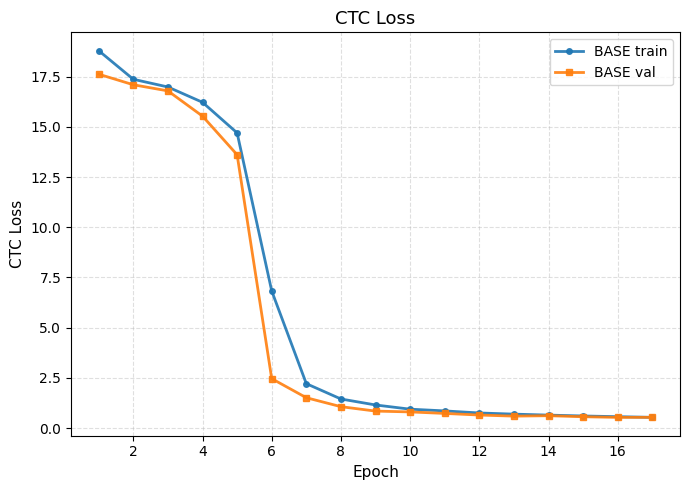

In [5]:
import json
import matplotlib.pyplot as plt

# =========================================================
# LOAD JSON FILES
# =========================================================
with open("../notebook_2/log_model_9b.json", "r") as f:
    base_log = json.load(f)

with open("../notebook_2/log_fintune.json", "r") as f:
    ft_log = json.load(f)

# =========================================================
# BASE MODEL HISTORY
# =========================================================
base_hist = base_log["training"]["history"]

base_epochs    = [h["epoch"] for h in base_hist]
base_loss      = [h["loss"] for h in base_hist]
base_val_loss  = [h["val_loss"] for h in base_hist]
base_cer       = [h["cer"] for h in base_hist]
base_exact     = [h["exact_match"] for h in base_hist]


plt.figure(figsize=(7, 5))

plt.plot(
    base_epochs,
    base_loss,
    label="BASE train",
    linewidth=2,
    marker="o",
    markersize=4,
    alpha=0.9
)

plt.plot(
    base_epochs,
    base_val_loss,
    label="BASE val",
    linewidth=2,
    marker="s",
    markersize=4,
    alpha=0.9
)

plt.xlabel("Epoch", fontsize=11)
plt.ylabel("CTC Loss", fontsize=11)
plt.title("CTC Loss", fontsize=13)

plt.legend(frameon=True)
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()



### 2. Pipeline Complète Modèle From Scratch Fine-Tuning

Même si notre modèle a montré une capacité de généralisation satisfaisante, notamment grâce à la diversité des sources de données utilisées lors de l’entraînement, les CAPTCHAs du site que nous avons scrappé présentaient une distribution visuelle significativement différente.

Dans ce contexte, afin d’améliorer les performances du modèle, nous avons procédé à une phase de fine-tuning directement sur des CAPTCHAs issus de ce site. Ces données ont été collectées via webscraping puis annotées manuellement par notre équipe.


In [ ]:
class EvalCallback(keras.callbacks.Callback):
    def __init__(self, infer_model, eval_ds, name="VAL", csv_path=None):
        super().__init__()
        self.infer_model = infer_model
        self.eval_ds = eval_ds
        self.name = name
        self.csv_path = csv_path

DATA_DIR_SITE = Path(
    r"C:\Users\jbche\OneDrive - Université Paris 1 Panthéon-Sorbonne\MOSEF\projets\webscrapping\projet\data\data_OCR_Captcha-20260117T105614Z-1-001\finetune_russie\data_russie"
)
SITE_CKPT_PATH   = "ocr_ctc_site_phaseA_best.keras"
FINAL_MODEL_PATH = "ANASTASIIA_JB_THEO_9B_PLUS_SITE.keras"
SEED = 42
def load_singlefolder_dataset(folder):
    files = list_images(folder)
    return (
        np.array([str(p) for p in files]),
        np.array([p.stem.lower() for p in files]),
        np.array(["site"] * len(files))
    )

def make_ds(x,y,bs,training=False,aug=None):
    ds = tf.data.Dataset.from_tensor_slices((x,y))
    if training:
        ds = ds.shuffle(min(len(x),200000),seed=SEED,reshuffle_each_iteration=True)
    ds = ds.map(lambda a,b:encode(a,b,training,aug),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.padded_batch(
        bs,
        padded_shapes={"image":[IMG_WIDTH,IMG_HEIGHT,1],"label":[None]},
        padding_values={"image":0.0,"label":-1},
        drop_remainder=training
    )
    return ds.prefetch(tf.data.AUTOTUNE)
SITE_CKPT_PATH = r"C:\Users\jbche\Desktop\ocr_ctc_site_phaseA_best.keras"

FINAL_MODEL_PATH = "ANASTASIIA_JB_THEO_9B2_PLUS_SITE.keras"
def aug_site_strong(img):
    # contrast / luminosité
    img = tf.image.random_brightness(img, 0.15)
    img = tf.image.random_contrast(img, 0.7, 1.4)


    img = tf.clip_by_value(
        img + tf.random.normal(tf.shape(img), 0, 0.02),
        0.0, 1.0
    )

    dx = tf.random.uniform([], -6, 6, dtype=tf.int32)
    img = tf.roll(img, shift=dx, axis=1)

 
    img = tf.image.random_crop(
        tf.pad(img, [[3,3],[6,6],[0,0]]),
        [IMG_HEIGHT, IMG_WIDTH, 1]
    )

    return img

def list_images(d):
    out = []
    for ext in ("*.png","*.jpg","*.jpeg"):
        out.extend(d.glob(ext))
    return sorted(out)

def split_by_source(paths, labels, sources):
    xtr,ytr,xv,yv,xt,yt = [],[],[],[],[],[]
    for s in np.unique(sources):
        idx = np.where(sources == s)[0]
        np.random.shuffle(idx)
        n = len(idx)
        ntr = int(TRAIN_FRAC*n)
        nva = int(VAL_FRAC*n)
        tr,va,te = idx[:ntr], idx[ntr:ntr+nva], idx[ntr+nva:]
        xtr+=paths[tr].tolist(); ytr+=labels[tr].tolist()
        xv +=paths[va].tolist(); yv +=labels[va].tolist()
        xt +=paths[te].tolist(); yt +=labels[te].tolist()
    return map(np.array,(xtr,ytr,xv,yv,xt,yt))
TRAIN_FRAC = 0.80
VAL_FRAC   = 0.10
TEST_FRAC  = 0.10

def encode(path,label,training=False,aug=None):
    img = tf.io.decode_image(tf.io.read_file(path),channels=1,expand_animations=False)
    img = tf.image.resize(tf.image.convert_image_dtype(img,tf.float32),
                          [IMG_HEIGHT,IMG_WIDTH])
    if training and aug:
        img = aug(img)
    img = tf.transpose(img,[1,0,2])
    label = char_to_num(tf.strings.unicode_split(label,"UTF-8"))
    return {"image":img,"label":tf.cast(label,tf.int32)}

chars = "0123456789abcdefghijklmnopqrstuvwxyz"
characters = list(chars)
num_chars = len(characters)
num_classes = num_chars + 1  # blank CTC

char_to_num = layers.StringLookup(
    vocabulary=characters,
    mask_token=None,
    num_oov_indices=0
)

site_p, site_l, site_s = load_singlefolder_dataset(DATA_DIR_SITE)
xtr, ytr, xv, yv, xt, yt = split_by_source(site_p, site_l, site_s)
BATCH_SIZE_SITE = 16
train_site = make_ds(xtr, ytr, BATCH_SIZE_SITE, True, aug_site_strong)
val_site   = make_ds(xv, yv, BATCH_SIZE_SITE)


model_ft = keras.models.load_model(
    BASE_CKPT_PATH,
    custom_objects={"CTCLayer": CTCLayer}
)
def build_infer_model(m):
    return keras.Model(
        inputs=m.inputs[0],              
        outputs=m.get_layer("char_softmax").output
    )

infer_ft = build_infer_model(model_ft)


for layer in model_ft.layers:
    if isinstance(layer, layers.Conv2D):
        layer.trainable = False
    if isinstance(layer, layers.LSTM):
        layer.trainable = True


for name in ["proj_dense", "char_softmax"]:
    model_ft.get_layer(name).trainable = True

model_ft.compile(
    optimizer=keras.optimizers.Adam(5e-4)  
)

model_ft.fit(
    train_site,
    validation_data=val_site,
    epochs=20,
    callbacks=[
        EvalCallback(infer_ft, val_site, "SITE_A"),
        keras.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True
        ),
        keras.callbacks.ModelCheckpoint(
            SITE_CKPT_PATH,
            save_best_only=True,
            monitor="val_loss",
            mode="min"
        ),
    ]
)

model_ft2 = keras.models.load_model(
    SITE_CKPT_PATH,
    custom_objects={"CTCLayer": CTCLayer}
)
infer_ft2 = build_infer_model(model_ft2)


for layer in model_ft2.layers:
    layer.trainable = True

for layer in model_ft2.layers:
    if isinstance(layer, layers.Conv2D):
        layer.trainable = False
        break  

model_ft2.compile(
    optimizer=keras.optimizers.Adam(1e-4)
)

model_ft2.fit(
    train_site,
    validation_data=val_site,
    epochs=15,
    callbacks=[
        EvalCallback(infer_ft2, val_site, "SITE_B"),
        keras.callbacks.EarlyStopping(
            patience=4,
            restore_best_weights=True
        ),
    ]
)

model_ft2.save(FINAL_MODEL_PATH)


# OCR CAPTCHA — Modèle Pré-entraîné (TrOCR)

Cette partie présente l’adaptation par fine-tuning du modèle TrOCR de Microsoft
sur les CAPTCHAs collectés par webscraping.

L’objectif est de comparer ses performances avec le modèle développé from scratch.

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DATA_DIR = r"..."
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")

TRAIN_FRAC = 0.9
MAX_LEN = 6

MODEL_CKPT = "microsoft/trocr-small-printed"

OUT_DIR_A = "./trocr_phaseA"
OUT_DIR_B = "./trocr_phaseB"
FINAL_DIR = "./trocr_final"

## Préparation des données
Séparation automatique des données en ensembles train et validation.

In [ ]:
%%sql
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)

if len(os.listdir(TRAIN_DIR)) == 0:
    files = [f for f in os.listdir(DATA_DIR)
             if f.lower().endswith((".png",".jpg",".jpeg"))]

    random.shuffle(files)
    n_train = int(TRAIN_FRAC * len(files))

    train_files = files[:n_train]
    val_files   = files[n_train:]

    for f in train_files:
        shutil.copy(os.path.join(DATA_DIR, f), TRAIN_DIR)

    for f in val_files:
        shutil.copy(os.path.join(DATA_DIR, f), VAL_DIR)

## Construction des labels
Les labels sont extraits à partir des noms de fichiers.

In [ ]:
def build_df(folder):
    files = [f for f in os.listdir(folder) if f.lower().endswith((".png",".jpg",".jpeg"))]
    df = pd.DataFrame(files, columns=["file_name"])
    df["text"] = df["file_name"].apply(lambda x: x.rsplit(".", 1)[0].lower())
    return df

train_df = build_df(TRAIN_DIR)
val_df   = build_df(VAL_DIR)

## Data Augmentation
Augmentations légères pour améliorer la robustesse.

In [ ]:
def augment_image(img: Image.Image) -> Image.Image:
    if random.random() < 0.5:
        img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2))
    if random.random() < 0.5:
        img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.3))
    if random.random() < 0.2:
        arr = np.array(img).astype(np.float32)
        noise = np.random.normal(0, 5, arr.shape)
        arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
        img = Image.fromarray(arr)
    if random.random() < 0.15:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.3, 0.8)))
    return img

## Dataset
Implémentation d’un Dataset pour charger et prétraiter les données.

In [ ]:
class CaptchaDataset(Dataset):
    def __init__(self, folder, df, processor, max_length=6, augment=False):
        self.folder = folder
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.max_length = max_length
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df.loc[idx, "file_name"]
        text = self.df.loc[idx, "text"]

        img_path = os.path.join(self.folder, file_name)
        image = Image.open(img_path).convert("RGB")
        if self.augment:
            image = augment_image(image)

        pixel_values = self.processor(image, return_tensors="pt").pixel_values[0]

        labels = self.processor.tokenizer(
            text,
            padding="max_length",
            max_length=self.max_length,
            truncation=True
        ).input_ids
        labels = [l if l != self.processor.tokenizer.pad_token_id else -100 for l in labels]

        return {"pixel_values": pixel_values, "labels": torch.tensor(labels, dtype=torch.long)}

train_ds = CaptchaDataset(TRAIN_DIR, train_df, processor, max_length=MAX_LEN, augment=True)
val_ds   = CaptchaDataset(VAL_DIR, val_df, processor, max_length=MAX_LEN, augment=False)

## Métriques
Évaluation via CER et Exact Match.

In [ ]:
def levenshtein(a: str, b: str) -> int:
    n, m = len(a), len(b)
    if n == 0: return m
    if m == 0: return n
    prev = list(range(m + 1))
    for i in range(1, n + 1):
        cur = [i] + [0] * m
        ai = a[i - 1]
        for j in range(1, m + 1):
            cost = 0 if ai == b[j - 1] else 1
            cur[j] = min(prev[j] + 1, cur[j - 1] + 1, prev[j - 1] + cost)
        prev = cur
    return prev[m]

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    pred_str = processor.batch_decode(preds, skip_special_tokens=True)

    labels = labels.copy()
    labels[labels == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels, skip_special_tokens=True)

    exact = float(np.mean([p == l for p, l in zip(pred_str, label_str)]))

    edits, chars = 0, 0
    for p, l in zip(pred_str, label_str):
        edits += levenshtein(p, l)
        chars += len(l)

    cer = edits / max(1, chars)
    return {"exact_acc": exact, "cer": cer}

## Phase A — Adaptation rapide
Entraînement du décodeur avec encodeur gelé.

In [ ]:
for p in model.encoder.parameters():
    p.requires_grad = False

args_A = Seq2SeqTrainingArguments(
    output_dir=OUT_DIR_A,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=3e-5,
    num_train_epochs=4,
    warmup_steps=20,

    eval_strategy="epoch",
    save_strategy="epoch",

    predict_with_generate=False,
    logging_strategy="epoch",

    fp16=False,
    report_to="none",

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args_A,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=default_data_collator,
    compute_metrics=None,
)

## Phase B — Fine-tuning global

In [ ]:
for p in model.encoder.parameters():
    p.requires_grad = True

args_B = Seq2SeqTrainingArguments(
    output_dir=OUT_DIR_B,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=1e-5,
    num_train_epochs=3,
    warmup_steps=10,

    eval_strategy="epoch",
    save_strategy="epoch",

    predict_with_generate=True,
    logging_strategy="epoch",

    fp16=False,
    report_to="none",

    load_best_model_at_end=True,
    metric_for_best_model="cer",
    greater_is_better=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args_B,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

## Conclusion — Fine-tuning du modèle TrOCR

Cette partie a permis de mettre en place une pipeline complète de fine-tuning
du modèle TrOCR, suivant une méthodologie comparable à celle utilisée pour
le modèle développé from scratch.

La stratégie en deux phases (gel puis dégel de l’encodeur) a permis
une adaptation progressive aux CAPTCHAs ciblés, tout en limitant
les risques de sur-apprentissage.

L’utilisation de data augmentation, d’un Dataset personnalisé
et de métriques spécifiques garantit une évaluation rigoureuse
des performances.

Le modèle obtenu constitue ainsi une base solide pour la comparaison
avec l’approche CNN + BiLSTM, présentée dans la section suivante.

# Conclusion générale

Ce projet a permis de développer un système complet de résolution
automatique de CAPTCHAs, depuis la collecte des données jusqu’au
déploiement d’un modèle fonctionnel.

Deux approches complémentaires ont été explorées :

- un modèle conçu from scratch, basé sur une architecture CNN + BiLSTM ;
- un modèle pré-entraîné TrOCR, adapté par fine-tuning.

L’approche from scratch offre une grande flexibilité et un contrôle
fin de l’architecture, mais nécessite un temps d’entraînement important.

À l’inverse, TrOCR permet une adaptation rapide grâce à l’apprentissage
par transfert, au prix d’une dépendance à un modèle externe.

Les résultats expérimentaux montrent que les deux approches sont pertinentes
dans un contexte de CAPTCHAs réels, chacune présentant des avantages
selon les contraintes de données, de calcul et de généralisation.


##  Benchmarking
Modèle from scratch vs Modèles préentraînés

| Modèle                      | Character Error Rate (CER) | Exact Match Accuracy | Time / Image |
|-----------------------------|----------------------------|----------------------|--------------|
| OCR FROM SCRATCH Fine-Tune  | 0.12                       | 67%                  | 1.45 sec     |
| TR OCR Fine-Tune            | 0.26                       | 39%                  | 0.59 sec     |